# Smoothness
---
The purpose of this notebook is to compute the smoothness of several model parameterization outputs w.r.t. some generated teacher outputs.

## Notebook configuration
Configure several notebook configuration settings.

In [1]:
# Disable some warnings

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [2]:
# Miscellaneous libraries
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import networkx as nx

from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# Setup some options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100


# Visualization
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

## Fetching data to analyze
---
Fetch all the generated `smoothness` csv files generated and analyze them.

In [3]:
!ls "../data/synthetic/erdos_renyi"

N100_n100_p0.1_1624367054 N200_n100_p0.1_1624514787
N100_n30_p0.1_1624230420  N300_n100_p0.1_1624629108


In [4]:
!ls "../data/synthetic/erdos_renyi/N300_n100_p0.1_1624629108/teacher_outputs/regression/GIN"

num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-1.0_upper1.0


In [5]:
!ls "../data/synthetic/erdos_renyi/N300_n100_p0.1_1624629108/teacher_outputs/regression/GIN/num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1"

1624722007352 1624722007877 1624722008336 1624722008801 1624722009261
1624722007645 1624722008105 1624722008567 1624722009032 1624722009492


In [7]:
teacher_outputs_prefix = \
    "../data/synthetic/erdos_renyi/N300_n100_p0.1_1624629108/" \
    "teacher_outputs/regression/GIN/num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1"

# Retrieve different teacher output configurations
teacher_outputs_filenames = [x for x in os.listdir(teacher_outputs_prefix) if all([c.isdigit() for c in x])]
#teacher_outputs_configs = ['__'.join(x.split('__')[:-1]) for x in teacher_outputs_filenames]
# Make sure to work only with the same teacher configurations
#assert teacher_outputs_configs.count(teacher_outputs_configs[0]) == len(teacher_outputs_configs), \
#    'Please specify teacher configuration! (there are more than one configuration available)'
print(f"Results over {len(teacher_outputs_filenames)} different teacher initializations, using the folowing configuration:")
#print(teacher_outputs_filenames[0][:-15])
print('num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1')

# Retrieve available student models
students = set([
    x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filenames[0]}/student_outputs') if x != '.DS_Store'
])
print()
print(f"Student outputs computed with the following models: {', '.join(students)}")

# Retrieve the different distance matrices used for computing the smoothness
dist_matrices = set()
for teacher_outputs_filename in teacher_outputs_filenames:
    dist_matrix_smoothness = [
        x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness') 
        if x.endswith('.csv')
    ]
    for dist_matrix in dist_matrix_smoothness:
        dist_matrices.add(dist_matrix.rstrip('.csv'))
print()
print(f"Smoothness computed with the following distance matrices: {', '.join(dist_matrices)}")

Results over 10 different teacher initializations, using the folowing configuration:
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1

Student outputs computed with the following models: GIN, Baseline, SGC, GCN, SIGN

Smoothness computed with the following distance matrices: WL__hashing__d3_iOnes__hamming__distance_sMaxdegree


---
Fix the `dist matrix` and the `teacher architecture`, and read all the available data for all the available combinations.

In [13]:
DIST_MATRIX = 'WL__hashing__d3_iOnes__hamming__distance_sMaxdegree'

In [28]:
# Define some auxiliary functions for reading the generated smoothness csv files
def readSmoothnessCSV(smoothness_filename):
    '''Auxiliary function to read a generated smoothness csv file.'''
    smoothness_stats = (pd.read_csv(smoothness_filename, header=[0, 1], index_col=[0, 1])
                          .reset_index()
                          .rename(columns={'level_0': 'model', 'level_1': 'model_config'}))
    # Add an extra column with the model type (for later processing)
    #smoothness_stats['model'] = [model] * len(smoothness_stats)
    # Rearange column order for better visualization
    #cols = smoothness_stats.columns.tolist()
    #cols = cols[-1:] + cols[:-1]
    return smoothness_stats #[cols]

In [31]:
# Test method with a sample
sample_filename = f"{teacher_outputs_prefix}/{teacher_outputs_filenames[0]}/smoothness/{DIST_MATRIX}.csv"
sample_smoothness_stats = readSmoothnessCSV(sample_filename)
# Save ordered columns for later processing
#ordered_cols = sample_smoothness_stats.columns.tolist()
sample_smoothness_stats

model                                       model_config  \
                                                                 
0  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
1  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
2       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
3       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
4      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
5       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   

                0                                                         1  \
  mean_smoothness std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0    8.803472e-08           0.000000  0.138966     0.000000             NaN   
1    1.604431e+05           0.000000  0.004690     0.000000             NaN   
2    3.903334e+04       46438.241926  0.810454     0.419771    18166.179309   
3    1.621753e+04       20533.757721  0.487748     0.292288    89982.016562   
4    1.005167e+04       12446.059070  0.579604     0.221927   118927.405417   
5    1.091749e+04        7192.024148  0.506261     0.112123   152231.950581   

                                                          2  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0                NaN       NaN          NaN             NaN   
1                NaN       NaN          NaN             NaN   
2       19953.304111  0.112127     0.033544    36107.304854   
3       35039.429293  0.048245     0.017789   133793.012290   
4       27502.199050  0.040547     0.009877   146496.601204   
5        3848.766386  0.034508     0.002916   150379.323435   

                                                          3  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0                NaN       NaN          NaN             NaN   
1                NaN       NaN          NaN             NaN   
2       37645.531015  0.094255     0.036292    54756.722931   
3       15040.947604  0.033272     0.002868   144697.534695   
4        3318.331566  0.034256     0.002450   148951.621011   
5        3317.077222  0.024347     0.004936   155546.983379   

                                                          4  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0                NaN       NaN          NaN             NaN   
1                NaN       NaN          NaN             NaN   
2       48492.870654  0.079372     0.033020    72111.393667   
3        2817.689053  0.032059     0.001359   145789.630259   
4         965.433862  0.033233     0.001724   149271.031123   
5        2879.288608  0.010865     0.006482   160039.422883   

                                                          5  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0                NaN       NaN          NaN             NaN   
1                NaN       NaN          NaN             NaN   
2       51370.209705  0.067360     0.027020    88096.118092   
3        1471.907601  0.032089     0.001334   145659.379250   
4         763.318864  0.032707     0.001092   149424.216502   
5        2830.119422  0.004482     0.002788   161647.963784   

                                                          6  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0                NaN       NaN          NaN             NaN   
1                NaN       NaN          NaN             NaN   
2       48714.777692  0.057916     0.020351   102586.141056   
3        1757.897439  0.032259     0.001138   145413.494680   
4         878.687782  0.032208     0.001132   149669.623383   
5         891.506963  0.003188     0.000390   162346.044183   

                                             
  std_dev_smoothness mean_rmse std_dev_rmse  
0                NaN       NaN          NaN  
1                NaN       NaN          NaN  
2       42809.015899  0.050909     0.013906  
3        1445.233966  0.032308     0.000959  
4         716.898183  0.031708     0.001024

In [32]:
# Gather all results for a given fixed teacher parameterization and a fixed distance matrix for computing the smoothness
smoothness_stats = pd.DataFrame()
for teacher_outputs_filename in tqdm(teacher_outputs_filenames):
    student_outputs_filename = \
        f"{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness/{DIST_MATRIX}.csv"
    smoothness_stats = smoothness_stats.append(
        readSmoothnessCSV(student_outputs_filename), ignore_index=True)
smoothness_stats = smoothness_stats[ordered_cols]
smoothness_stats

  0%|          | 0/10 [00:00<?, ?it/s]

model                                       model_config  \
                                                                  
0   Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
1   Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
2        SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
3        GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
4       SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
5        GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
6   Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
7   Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
8        SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
9        GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
10      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
11       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
12  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
13  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
14       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
15       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
16      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
17       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
18  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
19  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
20       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
21       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
22      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
23       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
24  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
25  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
26       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
27       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
28      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
29       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
30  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
31  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
32       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
33       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
34      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
35       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
36  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
37  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
38       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
39       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
40      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
41       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
42  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
43  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
44       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
45       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
46      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
47       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
48  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
49  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
50       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
51       GCN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
52      SIGN         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
53       GIN  num1_hidden32_blocks3_residualFalse_jkFalse__b...   
54  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
55  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
56       SGC         num1_hidden32_K3__bias0_lower-0.1_upper0.1   
57       GCN  num1_hidden32_blocks3_residualFalse_jkFa

Average the results throughout the different teacher initializations.

In [33]:
#warnings.filterwarnings('ignore', category='PerformanceWarning')

smoothness_stats_avg = smoothness_stats.groupby(['model', 'model_config']).mean()
smoothness_stats_avg

/Users/berges/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


0  \
                                                            mean_smoothness   
model    model_config                                                         
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...    3.733117e-09   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...    6.991332e+04   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...    1.224054e+04   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...    1.949573e+04   
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1            4.710972e+04   
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1            9.951874e+03   

                                                                                \
                                                            std_dev_smoothness   
model    model_config                                                            
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...           0.000000   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...           0.000000   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...       16202.686544   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...       28791.492318   
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1               40647.273621   
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1               12912.080622   

                                                                       \
                                                            mean_rmse   
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...  0.132903   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...  0.023536   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.827311   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...  0.621263   
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1          1.740499   
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1          0.826288   

                                                                          \
                                                            std_dev_rmse   
model    model_config                                                      
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...     0.000000   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...     0.000000   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...     0.576700   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...     0.342795   
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1             0.888203   
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1             0.549815   

                                                                          1  \
                                                            mean_smoothness   
model    model_config                                                         
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...             NaN   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...             NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...    36168.764612   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...    67941.985647   
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1            20460.237558   
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1            48475.523644   

                                                                                \
                                                            std_dev_smoothness   
model    model_config                                                            
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...                NaN   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...                NaN   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...       12635.786638   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...        1596.3519

## Visualization
---
Visualize the **averaged** obtained results.

In [46]:
# Define some auxiliary functions for ploting
def getAllStats(smoothness_stats_avg):
    '''Auxiliary function that retrieves all the separated data for each of the observable columns.'''
    all_stats = {}
    data_cols = [col for col in smoothness_stats_avg.columns.get_level_values(1).unique() if col]
    for data_col in data_cols:
        all_stats[data_col] = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(1) == data_col]
        all_stats[data_col].columns = all_stats[data_col].columns.droplevel(1)
    return all_stats


def plotSmoothnessRMSE(ax, ax_twin, all_stats, model_config):
    '''
    
    
    Parameters:
        - ax
        - ax2
        - all_stats
        - model_config
    
    
    '''
    # Retrieve Y-axis variables
    mean_smoothness = all_stats['mean_smoothness'].loc[model_config].to_numpy()
    std_dev_smoothness = all_stats['std_dev_smoothness'].loc[model_config].to_numpy()
    mean_rmse = all_stats['mean_rmse'].loc[model_config].to_numpy()
    std_dev_rmse = all_stats['std_dev_rmse'].loc[model_config].to_numpy()
    # X-axis
    n = len(mean_smoothness)
    x = np.arange(n)
    if model_config[0] == 'Baseline':
        # Plot the 'constant' smoothness and rmse
        ax.axhline(y=mean_smoothness[0], color='b', label=f"{model_config[0]} ({model_config[1]})")
        ax_twin.axhline(y=mean_rmse[0], color='b', ls='--', label=f"{model_config[0]} ({model_config[1]})")
    else:
        # Plot the mean and standard deviation of the smoothness
        ax.plot(x, mean_smoothness, label=f"{model_config[0]} ({model_config[1]})")
        ax.fill_between(x, (mean_smoothness - std_dev_smoothness), (mean_smoothness + std_dev_smoothness), alpha=0.1)
        # Plot the mean and standard deviation of the smoothness
        ax_twin.plot(x, mean_rmse, ls='--', label=f"{model_config[0]} ({model_config[1]})")
        ax_twin.fill_between(x, (mean_rmse - std_dev_rmse), (mean_rmse + std_dev_rmse), alpha=0.1)
    # Fix ticks and limit ranges
    #ax.set_ylim(bottom=0, top=1)
    ax.set_xlim(left=x[0], right=x[-1])
    ax.set_xticks(x)
    # Add title and axis labels
    ax.set_title('Smoothness & RMSE during training', fontsize=18)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Smoothness (---)', fontsize=14)
    ax_twin.set_ylabel('RMSE (-  -  -)', fontsize=14)
    # Visualize legend
    ax.legend()


Visualizing smoothness with the following configuration:

    • Teacher configuration used: GIN (num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1)
    • Distance matrix used: WL__hashing__d3_iOnes__hamming__distance_sMaxdegree





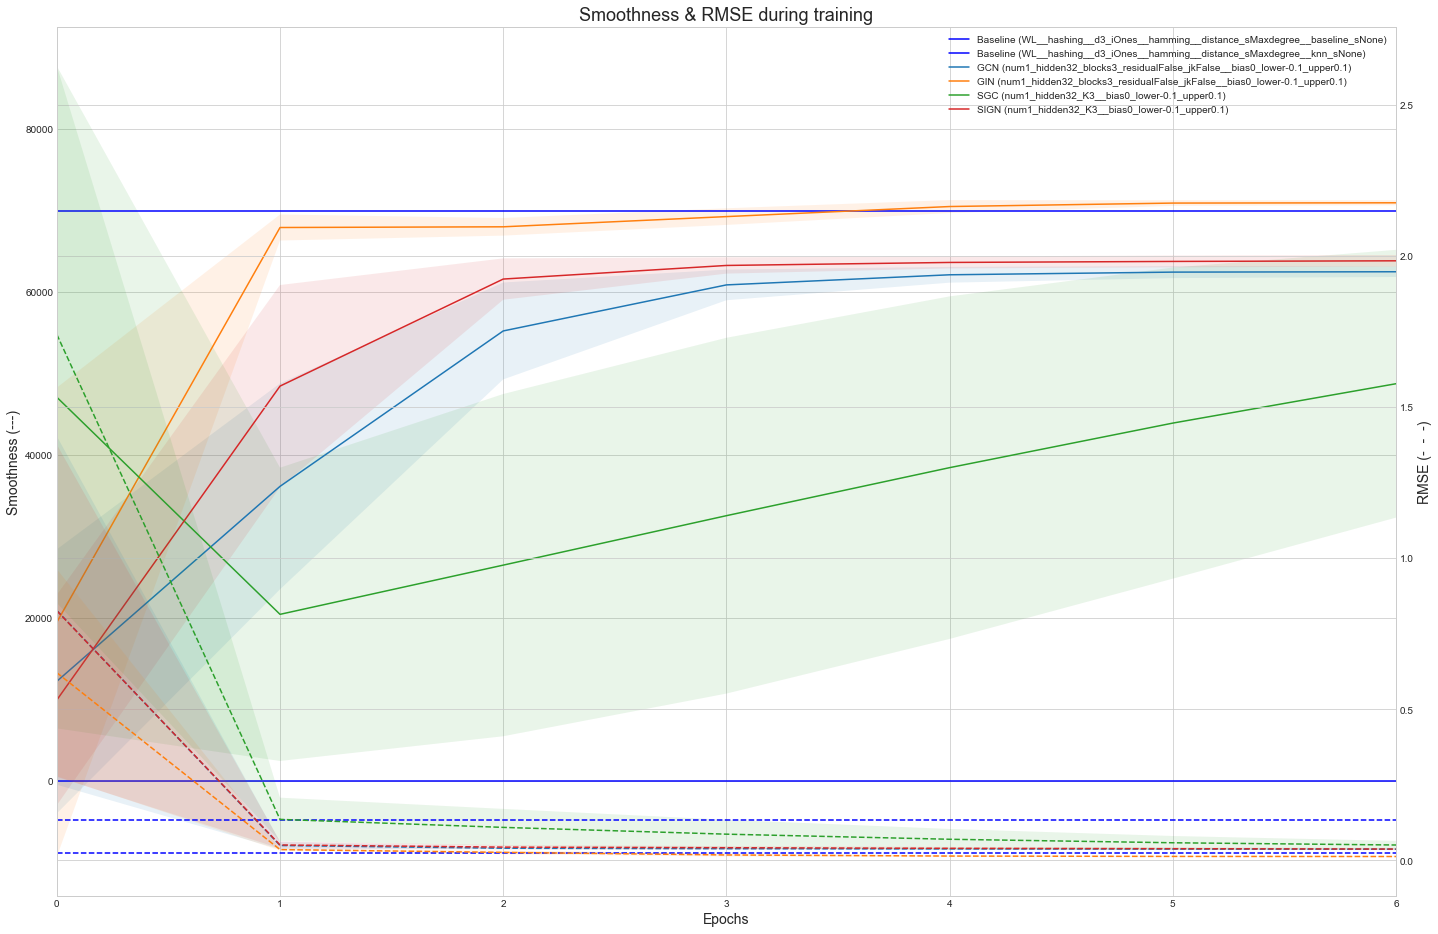

In [47]:
# Retrieve all model parameterizations
model_configs = smoothness_stats_avg.index.tolist()
# Retrieve all the column-split data
all_stats = getAllStats(smoothness_stats_avg)

# Create the figure and plot everything
fig, ax = plt.subplots(1, 1, figsize=(24, 16))
ax_twin = ax.twinx()


for i, model_config in enumerate(model_configs):
    plotSmoothnessRMSE(ax, ax_twin, all_stats, model_config)


print_info = f"""
Visualizing smoothness with the following configuration:

    \u2022 Teacher configuration used: \033[4mGIN (num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1)\033[0m
    \u2022 Distance matrix used: \033[4m{DIST_MATRIX}\033[0m


"""
print(print_info)
plt.show()

Take the *final* results and make a scatter plot.

In [50]:
baseline_configs = [x for x in smoothness_stats_avg.index.tolist() if x[0] == 'Baseline']
smoothness_stats_avg_final = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(0) == '6']
smoothness_stats_avg_final.columns = smoothness_stats_avg_final.columns.droplevel(0)
# Since the baseline is not trained, substitute with the initial values
for baseline_config in baseline_configs:
    aux = smoothness_stats_avg.loc[baseline_config, smoothness_stats_avg.columns.get_level_values(0) == '0']
    aux.index = aux.index.droplevel(0)
    smoothness_stats_avg_final.loc[baseline_config] = aux

smoothness_stats_avg_final

/Users/berges/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/berges/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


mean_smoothness  \
model    model_config                                                          
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...     3.733117e-09   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...     6.991332e+04   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...     6.251114e+04   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...     7.097584e+04   
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1             4.876822e+04   
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1             6.385455e+04   

                                                             std_dev_smoothness  \
model    model_config                                                             
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...            0.000000   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...            0.000000   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...          642.327584   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...          306.166303   
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1                16432.272710   
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1                  712.720013   

                                                             mean_rmse  \
model    model_config                                                    
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...   0.132903   
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...   0.023536   
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...   0.037168   
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...   0.013011   
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1           0.051085   
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1           0.037664   

                                                             std_dev_rmse  
model    model_config                                                      
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...      0.000000  
         WL__hashing__d3_iOnes__hamming__distance_sMaxde...      0.000000  
GCN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...      0.002046  
GIN      num1_hidden32_blocks3_residualFalse_jkFalse__bi...      0.000858  
SGC      num1_hidden32_K3__bias0_lower-0.1_upper0.1              0.013654  
SIGN     num1_hidden32_K3__bias0_lower-0.1_upper0.1              0.003780

/Users/berges/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


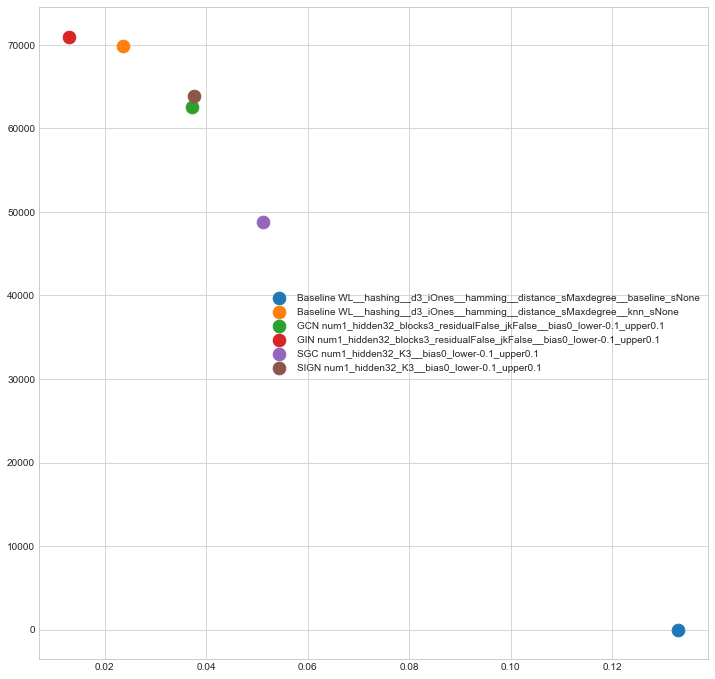

In [51]:
# Make a scatter plot with the results
smoothness_stats_avg_final['model_config'] = [x[0] + ' ' + x[1] for x in smoothness_stats_avg_final.index.tolist()]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for i in range(len(smoothness_stats_avg_final)):
    x = smoothness_stats_avg_final['mean_rmse'].tolist()[i]
    y = smoothness_stats_avg_final['mean_smoothness'].tolist()[i]
    c = smoothness_stats_avg_final['model_config'].tolist()[i]
    ax.scatter(x, y, s=160, label=c)

ax.legend(loc=7)


plt.show()